# Estudo de Caso 1: Sistemas de Recomendação na Amazon

## Introdução

Este estudo explora a construção de sistemas de recomendação aplicados ao ambiente de comércio eletrônico da Amazon. Os sistemas de recomendação são ferramentas indispensáveis para personalizar a experiência do usuário e aumentar a eficiência das vendas online. O objetivo principal é desenvolver um modelo capaz de sugerir produtos relevantes para os clientes com base em seus históricos de interações.

O conjunto de dados utilizado faz parte do [Amazon Electronics Rating Dataset](https://www.kaggle.com/datasets/vibivij/amazon-electronics-rating-datasetrecommendation/data), contendo informações sobre avaliações realizadas por usuários, como identificadores de usuários e produtos, além das notas atribuídas. Este estudo segue as seguintes etapas:
- Análise exploratória do conjunto de dados.
- Implementação de modelos de recomendação utilizando os algoritmos KNN e K-Means.
- Comparação do desempenho entre as abordagens, com base em métricas específicas.
- Discussão das diferenças metodológicas e dos resultados obtidos.
- Propostas de melhorias no sistema de recomendação.

Com isso, busca-se não apenas atender aos objetivos técnicos do estudo, mas também explorar os desafios e potencialidades associados à criação de sistemas de recomendação em larga escala.

---

# Contexto da Base de Dados

A base de dados utilizada neste estudo foi criada com o objetivo de analisar o comportamento dos consumidores da Amazon, particularmente no domínio das avaliações de produtos eletrônicos. O conjunto de dados é uma fonte rica para entender as interações dos usuários com produtos e serve como base para a construção de sistemas de recomendação.

## Características

- **Estrutura Simples**: O dataset contém informações sobre as interações de usuários com produtos eletrônicos.
- **Atributos Incluídos**:
  - **userId**: Identificador exclusivo de cada usuário.
  - **productId**: Identificador exclusivo de cada produto.
  - **Rating**: Nota atribuída pelo usuário ao produto (escala de 1 a 5).
  - **Timestamp**: Data e hora da avaliação (não utilizada neste estudo).
- **Objetivo**: Servir como base para a construção de um sistema de recomendação capaz de identificar produtos relevantes para os consumidores, com base no histórico de avaliações.

## Observações Importantes

- Os dados são reais e refletem padrões típicos de consumo e avaliação de produtos eletrônicos.
- O atributo `Rating` será o foco principal da análise, pois representa as preferências do usuário e permite inferir padrões de recomendação.
- Embora o `Timestamp` esteja presente, ele não será utilizado, uma vez que o objetivo não envolve análises temporais.

Este conjunto de dados oferece uma excelente oportunidade para explorar técnicas de sistemas de recomendação e entender as preferências dos consumidores no ambiente de comércio eletrônico.


# Bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Importação dos Dados

In [ ]:
df = pd.read_csv('ratings_Electronics.csv')
df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


# Visualização dos Dados

In [ ]:
# Verificar o número de linhas e colunas do DataFrame
rows, columns = df.shape
print(f"O DataFrame possui {rows} linhas e {columns} colunas.")

O DataFrame possui 7824481 linhas e 4 colunas.


In [ ]:
# Verificar colunas com valores nulos e exibi-las
missing_data_info = df.isnull().sum().sort_values(ascending=False)
missing_data_df = pd.DataFrame({
    'Coluna': missing_data_info.index,
    'Valores Ausentes': missing_data_info.values,
    'Percentual (%)': (missing_data_info.values / len(df)) * 100
})

# Filtrar apenas colunas com valores ausentes
missing_data_df = missing_data_df[missing_data_df['Valores Ausentes'] > 0]
print(missing_data_df)

Empty DataFrame
Columns: [Coluna, Valores Ausentes, Percentual (%)]
Index: []


In [ ]:
# Verificar duplicatas
duplicate_rows = df.duplicated().sum()
print(f"Número de linhas duplicadas: {duplicate_rows}")

# Remover duplicatas, se existirem
df = df.drop_duplicates()

Número de linhas duplicadas: 0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   AKM1MP6P0OYPR  object 
 1   0132793040     object 
 2   5.0            float64
 3   1365811200     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


# Transformação dos Dados

In [ ]:
# Renomeando as colunas do DataFrame
df.columns = ['userId', 'productId', 'rating', 'timestamp']

# Exibindo as primeiras linhas para verificar
df.head()

,userId,productId,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [ ]:
# Dropar a coluna timestamp
df = df.drop(columns=['timestamp'])

# Etapa 1: Análise Exploratória

In [ ]:
# Contando a frequência de cada usuário
top_users = df['userId'].value_counts().head(5)

# Exibindo os resultados com f-string
for i, (user, count) in enumerate(top_users.items(), start=1):
    print(f"Top {i}: Usuário '{user}' realizou {count} avaliações.")

Top 1: Usuário 'A5JLAU2ARJ0BO' realizou 520 avaliações.
Top 2: Usuário 'ADLVFFE4VBT8' realizou 501 avaliações.
Top 3: Usuário 'A3OXHLG6DIBRW8' realizou 498 avaliações.
Top 4: Usuário 'A6FIAB28IS79' realizou 431 avaliações.
Top 5: Usuário 'A680RUE1FDO8B' realizou 406 avaliações.


In [ ]:
# Calculando o número de avaliações e a média do rating por produto
product_summary = df.groupby('productId').agg(
    quantidade=('rating', 'count'),
    media_rating=('rating', 'mean')
).sort_values(by='quantidade', ascending=False).head(5)

# Exibindo os resultados com f-string
for i, (product, data) in enumerate(product_summary.iterrows(), start=1):
    print(f"Top {i}: Produto '{product}' foi avaliado {int(data['quantidade'])} vezes, com média de rating {data['media_rating']:.2f}.")

Top 1: Produto 'B0074BW614' foi avaliado 18244 vezes, com média de rating 4.49.
Top 2: Produto 'B00DR0PDNE' foi avaliado 16454 vezes, com média de rating 3.93.
Top 3: Produto 'B007WTAJTO' foi avaliado 14172 vezes, com média de rating 4.42.
Top 4: Produto 'B0019EHU8G' foi avaliado 12285 vezes, com média de rating 4.75.
Top 5: Produto 'B006GWO5WK' foi avaliado 12226 vezes, com média de rating 4.31.


In [ ]:
# Produtos com piores avaliações
worst_rated = df.groupby('productId')['rating'].mean().sort_values(ascending=True).head(5)
print("Piores produtos:", worst_rated)

Piores produtos: productId
B0063IZ8SM    1.0
B00BQRMG44    1.0
B001MXA50Y    1.0
B004811DCQ    1.0
B001MXBSPK    1.0
Name: rating, dtype: float64


In [ ]:
# Produtos mais bem avaliados
best_rated = df.groupby('productId')['rating'].mean().sort_values(ascending=False).head(5)
print("Melhores produtos:", best_rated)

Melhores produtos: productId
0321732944    5.0
B004SGJ030    5.0
B004SQC6O0    5.0
B004SQE6YI    5.0
B004SQFFCK    5.0
Name: rating, dtype: float64


In [ ]:
# Contagem de frequência por rating
rating_counts = df['rating'].value_counts().sort_index()
print(rating_counts)

rating
1.0     901765
2.0     456322
3.0     633073
4.0    1485781
5.0    4347540
Name: count, dtype: int64


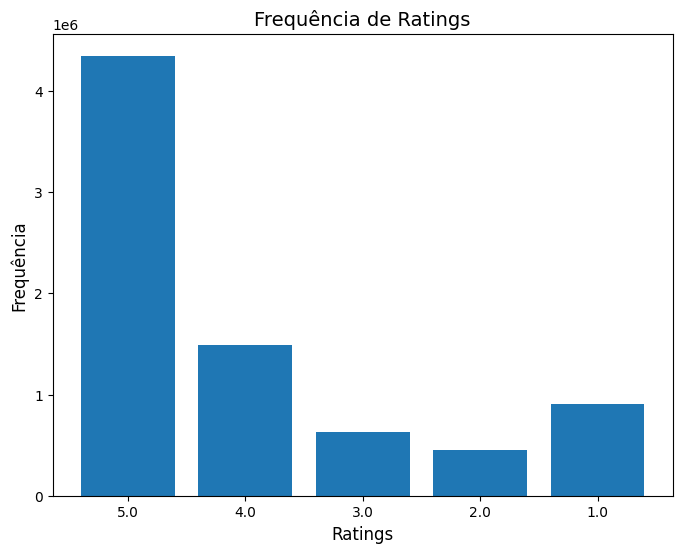

In [ ]:
# Calculando a contagem de frequência por rating
rating_counts = df['rating'].value_counts().sort_index(ascending=False)

# Gráfico de barras ordenado do maior para o menor
plt.figure(figsize=(8, 6))
plt.bar(rating_counts.index.astype(str), rating_counts.values)
plt.xlabel('Ratings', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.title('Frequência de Ratings', fontsize=14)
plt.xticks(rotation=0)
plt.show()

## Etapa 2: Sistema de Recomendação com KNN

Nesta etapa, criaremos um sistema de recomendação utilizando o algoritmo **KNN (K-Nearest Neighbors)** para sugerir produtos com base na similaridade entre usuários ou produtos.

### Passos Resumidos:
1. **Preparação dos Dados**:
   - Criar uma matriz de interações usuário-produto.
2. **Cálculo da Similaridade**:
   - Utilizar métricas como similaridade de cosseno ou correlação de Pearson.
3. **Implementação do KNN**:
   - Identificar os k vizinhos mais próximos para prever ratings.
4. **Geração de Recomendações**:
   - Sugerir produtos mais relevantes para cada usuário.
5. **Avaliação do Modelo**:
   - Validar a precisão com métricas como RMSE ou MAE.

O objetivo é obter recomendações personalizadas baseadas em interações anteriores e padrões de similaridade.

In [ ]:
# Verificar o tamanho inicial do DataFrame
print(f"DataFrame original: {df.shape[0]} linhas e {df.shape[1]} colunas.")

# Filtrar usuários e produtos mais ativos para reduzir tamanho da matriz
top_users = df['userId'].value_counts().head(5000).index  # Top 5000 usuários mais ativos
top_products = df['productId'].value_counts().head(5000).index  # Top 5000 produtos mais avaliados

df_filtered = df[df['userId'].isin(top_users) & df['productId'].isin(top_products)]
print(f"DataFrame filtrado: {df_filtered.shape[0]} linhas e {df_filtered.shape[1]} colunas.")

# Criar matriz de interação usuário-produto
user_product_matrix = df_filtered.pivot_table(index='userId', columns='productId', values='rating').fillna(0)

# Converter a matriz para uma matriz esparsa
sparse_matrix = csr_matrix(user_product_matrix)

# Treinar o modelo KNN
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)
knn.fit(sparse_matrix)

# Função para recomendar produtos
def recomendar_produtos(usuario_id, n_vizinhos=5, n_recomendacoes=5):
    try:
        # Encontrar o índice do usuário
        usuario_idx = user_product_matrix.index.tolist().index(usuario_id)
    except ValueError:
        return f"Usuário {usuario_id} não encontrado no dataset."

    # Encontrar os vizinhos mais próximos
    distances, indices = knn.kneighbors(sparse_matrix[usuario_idx], n_neighbors=n_vizinhos + 1)
    similar_users = indices.flatten()[1:]  # Excluir o próprio usuário

    # Agregar produtos avaliados pelos vizinhos
    produtos_avaliados = user_product_matrix.iloc[similar_users].sum(axis=0).sort_values(ascending=False)

    # Filtrar produtos que o usuário já avaliou
    produtos_ja_avaliados = user_product_matrix.loc[usuario_id]
    recomendacoes = produtos_avaliados[produtos_ja_avaliados == 0].head(n_recomendacoes)

    return recomendacoes.index.tolist()

# Exemplo de recomendação para um usuário
#usuario_exemplo = 'A2WU7IKAQINJAY'  # Substitua por um userId real do dataset
#recomendacoes = recomendar_produtos(usuario_exemplo, n_vizinhos=5, n_recomendacoes=5)
#print(f"Recomendações para o usuário {usuario_exemplo}: {recomendacoes}")

# Escolher um usuário aleatório do subconjunto filtrado
usuario_exemplo = np.random.choice(user_product_matrix.index)
print(f"Novo usuário exemplo: {usuario_exemplo}")

recomendacoes = recomendar_produtos(usuario_exemplo, n_vizinhos=5, n_recomendacoes=5)
print(f"Recomendações para o usuário {usuario_exemplo}: {recomendacoes}")

DataFrame original: 7824481 linhas e 3 colunas.
DataFrame filtrado: 84209 linhas e 3 colunas.
Novo usuário exemplo: A2ARKEEDO6679D
Recomendações para o usuário A2ARKEEDO6679D: ['B0002L5R78', 'B009OZUPUC', 'B00DE0EPCM', 'B0061R1XI4', 'B001GTT0VO']


In [ ]:
def avaliar_modelo(user_product_matrix, knn, n_vizinhos=5):
    # Listas para armazenar ratings reais e previstos
    ratings_reais = []
    ratings_previstos = []

    # Avaliar para cada usuário no subconjunto
    for usuario_id in user_product_matrix.index:
        try:
            # Encontrar o índice do usuário
            usuario_idx = user_product_matrix.index.tolist().index(usuario_id)

            # Encontrar os vizinhos mais próximos
            distances, indices = knn.kneighbors(sparse_matrix[usuario_idx], n_neighbors=n_vizinhos + 1)
            similar_users = indices.flatten()[1:]  # Excluir o próprio usuário

            # Agregar produtos avaliados pelos vizinhos
            produtos_avaliados = user_product_matrix.iloc[similar_users].sum(axis=0)

            # Recuperar os ratings reais e previstos
            for produto_id in user_product_matrix.columns:
                rating_real = user_product_matrix.at[usuario_id, produto_id]
                if rating_real > 0:  # Avaliar apenas produtos com ratings reais
                    rating_previsto = produtos_avaliados[produto_id] / (len(similar_users) or 1)
                    ratings_reais.append(rating_real)
                    ratings_previstos.append(rating_previsto)
        except ValueError:
            continue

    # Calcular RMSE e MAE
    rmse = sqrt(mean_squared_error(ratings_reais, ratings_previstos))
    mae = mean_absolute_error(ratings_reais, ratings_previstos)

    return rmse, mae

# Avaliar o modelo
rmse, mae = avaliar_modelo(user_product_matrix, knn, n_vizinhos=5)
print(f"RMSE do modelo: {rmse:.4f}")
print(f"MAE do modelo: {mae:.4f}")

RMSE do modelo: 3.9058
MAE do modelo: 3.6951


# Etapas do Sistema de Recomendação com KNN

## 1. Redução do Tamanho da Base
Para melhorar o desempenho, filtramos os 5.000 usuários mais ativos (com maior número de avaliações) e os 5.000 produtos mais avaliados. Isso reduz o tamanho do DataFrame, tornando a matriz de interação mais manejável para o modelo.

---

## 2. Criar a Matriz de Interação
Transformamos os dados filtrados em uma matriz de interação, onde:
- Linhas representam usuários.
- Colunas representam produtos.
- Os valores correspondem às avaliações (ratings) dos usuários para os produtos.
Caso um produto não tenha sido avaliado, o valor é preenchido como 0.

---

## 3. Treinamento do Modelo KNN
Utilizamos o algoritmo **KNN (K-Nearest Neighbors)** para identificar usuários vizinhos com comportamentos semelhantes. O modelo é treinado utilizando a métrica de similaridade de cosseno e uma matriz esparsa para otimizar o armazenamento e o processamento.

---

## 4. Sistema de Recomendação
Com base no modelo treinado, a função de recomendação realiza os seguintes passos:
1. Encontra os vizinhos mais próximos de um usuário específico.
2. Soma os ratings dos vizinhos para cada produto.
3. Filtra produtos já avaliados pelo usuário.
4. Retorna uma lista dos produtos mais relevantes.

---

## 5. Avaliação do Modelo

Para validar o modelo, utilizamos as métricas:
- **RMSE (Root Mean Squared Error)**: Mede o erro quadrático médio das previsões, penalizando mais erros grandes.
- **MAE (Mean Absolute Error)**: Mede o erro absoluto médio entre as previsões e os valores reais.

### Resultados Obtidos:
- **RMSE**: 3.9058
- **MAE**: 3.6951

### Interpretação dos Resultados:
- **RMSE (Root Mean Squared Error)**:
  - Penaliza mais os erros grandes.
  - Um valor próximo de 4 sugere que as previsões do modelo estão frequentemente longe dos ratings reais, especialmente em casos extremos.

- **MAE (Mean Absolute Error)**:
  - Mede a diferença média entre previsões e ratings reais.
  - Um valor próximo de 3.7 implica que o modelo está errando em média por quase 4 pontos na escala de avaliação (1-5).

### Possíveis Implicações:
- O modelo pode estar generalizando demais, o que reduz sua precisão.
- A matriz de interação pode sofrer de problemas de sparsidade (muitos ratings ausentes).
- Os vizinhos mais próximos identificados pelo modelo podem não estar suficientemente representativos para as recomendações.

---

## Impacto da Amostragem nos Resultados do Modelo

### Como a Amostragem Pode Afetar o Modelo
1. **Redução de Diversidade**:
   - Filtrar apenas os 5.000 usuários mais ativos e os 5.000 produtos mais avaliados pode reduzir a diversidade nos comportamentos dos usuários e características dos produtos, o que pode levar o modelo a generalizar demais.

2. **Perda de Dados Relevantes**:
   - Ao excluir usuários menos ativos e produtos menos avaliados, perdemos informações que poderiam capturar padrões gerais de comportamento no dataset.

3. **Persistência da Sparsidade**:
   - Mesmo após o filtro, a matriz de interação continua sendo esparsa (grande proporção de zeros), dificultando a identificação de similaridades precisas entre usuários e produtos.

---

### Como Testar se a Amostragem é o Problema
1. **Aumentar o Número de Usuários e Produtos**:
   - Incluir mais usuários e produtos no subconjunto para capturar maior diversidade. Por exemplo:
     - Aumentar de 5.000 para 10.000 ou mais usuários e produtos.

2. **Comparar com a Base Completa**:
   - Executar o modelo utilizando a base completa (se o desempenho computacional permitir) para verificar se os resultados são melhores.

3. **Analisar a Sparsidade**:
   - Calcular a proporção de valores preenchidos na matriz de interação antes e depois da amostragem. Sparsidade alta pode indicar que o modelo está treinando com informações insuficientes.

4. **Testar Diferentes Amostragens**:
   - Experimentar diferentes subconjuntos de dados, como incluir usuários menos ativos ou produtos menos avaliados, e observar o impacto nos resultados.

---

### Melhorias Possíveis
1. **Ajustar os Parâmetros de Filtragem**:
   - Expandir os limites de usuários e produtos incluídos no subconjunto para garantir maior representatividade.

2. **Normalizar os Ratings**:
   - Subtrair a média dos ratings de cada usuário para reduzir o impacto de outliers e melhorar a precisão das previsões.

3. **Experimentar Outros Algoritmos**:
   - Modelos como **Matrix Factorization** ou **SVD (Singular Value Decomposition)** são mais robustos para lidar com matrizes esparsas e podem melhorar os resultados.

4. **Aumentar o Subconjunto Gradualmente**:
   - Avaliar o impacto do tamanho do subconjunto nos resultados, aumentando progressivamente o número de usuários e produtos incluídos.

---

### Conclusão
Os resultados do modelo podem estar sendo impactados pela amostragem reduzida, que pode não representar bem o comportamento geral dos usuários e produtos. Realizar testes com diferentes tamanhos de subconjuntos e estratégias de filtragem é essencial para determinar se a amostragem é a principal causa dos erros observados no **RMSE** e **MAE**.

---

# Etapa 3: Sistema de Recomendação com K-Means

In [ ]:
# Criar matriz de interação usuário-produto (ou produto-usuário)
user_product_matrix = df_filtered.pivot_table(index='userId', columns='productId', values='rating').fillna(0)

# Aplicar o K-Means
n_clusters = 2  # Número de clusters (pode ser ajustado com base no método do cotovelo)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Treinar o modelo
kmeans.fit(user_product_matrix)

# Adicionar a coluna de clusters ao DataFrame de usuários
user_clusters = pd.DataFrame({
    'userId': user_product_matrix.index,
    'cluster': kmeans.labels_
})

# Exibir os clusters formados
print(user_clusters.head())

# Função para recomendar produtos
def recomendar_produtos_kmeans(usuario_id, n_recomendacoes=5):
    # Verificar o cluster do usuário
    cluster_usuario = user_clusters[user_clusters['userId'] == usuario_id]['cluster'].values[0]

    # Identificar todos os usuários no mesmo cluster
    usuarios_similares = user_clusters[user_clusters['cluster'] == cluster_usuario]['userId']

    # Filtrar avaliações desses usuários
    produtos_cluster = user_product_matrix.loc[usuarios_similares].sum(axis=0).sort_values(ascending=False)

    # Filtrar produtos já avaliados pelo usuário
    produtos_ja_avaliados = user_product_matrix.loc[usuario_id]
    recomendacoes = produtos_cluster[produtos_ja_avaliados == 0].head(n_recomendacoes)

    return recomendacoes.index.tolist()

# Exemplo de recomendação
usuario_exemplo = user_product_matrix.index[0]
recomendacoes = recomendar_produtos_kmeans(usuario_exemplo, n_recomendacoes=5)
print(f"Recomendações para o usuário {usuario_exemplo}: {recomendacoes}")


           userId  cluster
0  A100UD67AHFODS        0
1  A100WO06OQR8BQ        1
2  A10471FSILZ25C        0
3  A105S56ODHGJEK        1
4  A105TOJ6LTVMBG        0
Recomendações para o usuário A100UD67AHFODS: ['B007WTAJTO', 'B003ES5ZUU', 'B002WE6D44', 'B002V88HFE', 'B0019EHU8G']


Silhouette Score: 0.11


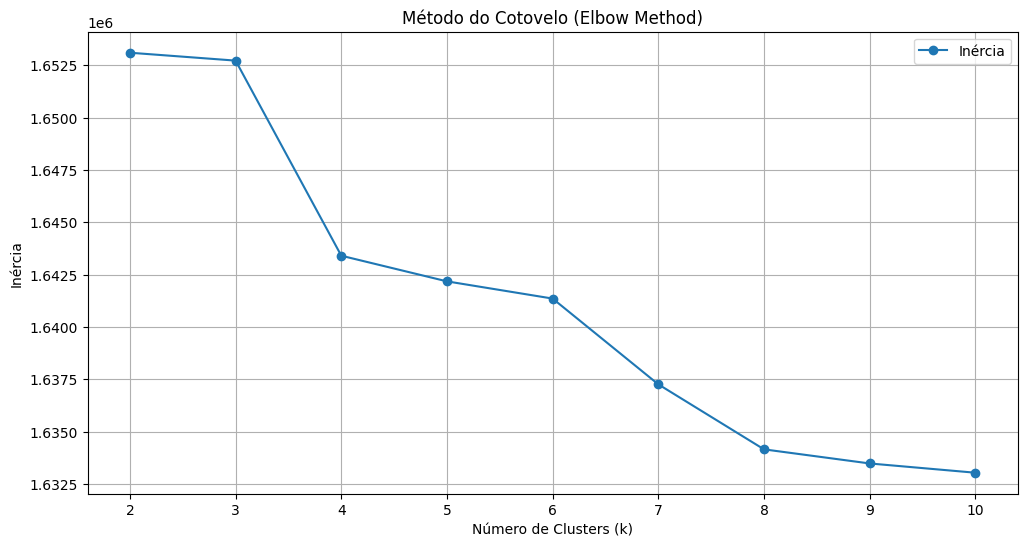

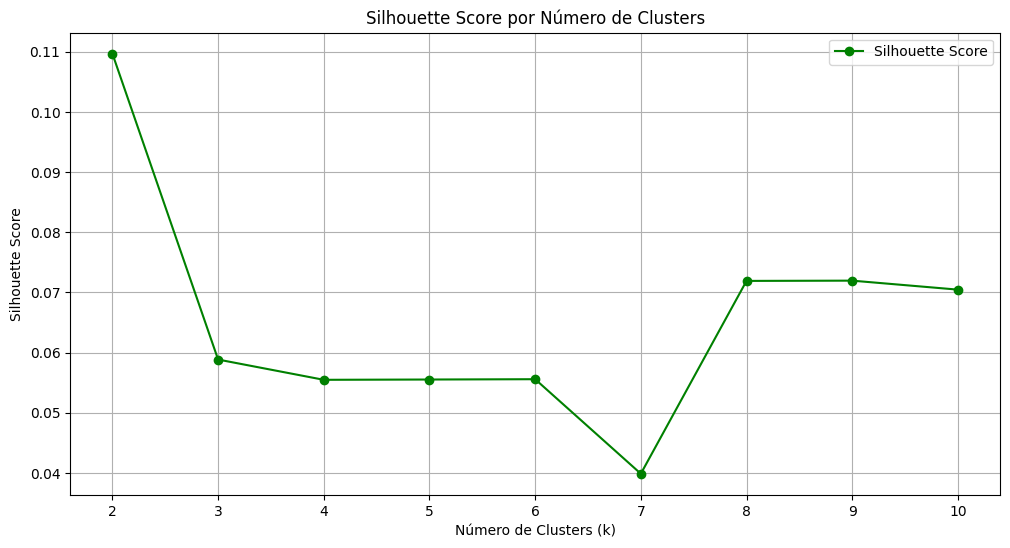

In [ ]:
#------------------------------------------------
# Avaliação do Silhouette Score
#------------------------------------------------
# Calcula o Silhouette Score para os clusters formados
silhouette_avg = silhouette_score(user_product_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.2f}")

#------------------------------------------------
# Avaliação da Inércia e Método do Cotovelo
#------------------------------------------------
# Lista para armazenar as inércias
inertias = []
silhouette_scores = []
k_values = range(2, 11)  # Testando diferentes números de clusters (k)

# Calcula a inércia para diferentes valores de k
for k in k_values:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(user_product_matrix)
    inertias.append(kmeans_test.inertia_)

    # Calcula o Silhouette Score para cada k
    score = silhouette_score(user_product_matrix, kmeans_test.labels_)
    silhouette_scores.append(score)

# Plotando o Método do Cotovelo
plt.figure(figsize=(12, 6))
plt.plot(k_values, inertias, marker='o', label='Inércia')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.legend()
plt.grid()
plt.show()

# Plotando o Silhouette Score para diferentes k
plt.figure(figsize=(12, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='green', label='Silhouette Score')
plt.title('Silhouette Score por Número de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid()
plt.show()


# Etapas do Sistema K-Means

# Sistema de Recomendação com K-Means

O algoritmo **K-Means** é utilizado para agrupar dados com base em sua similaridade. Ele pode ser aplicado em sistemas de recomendação para identificar padrões e oferecer sugestões personalizadas.

---

## Etapas do Sistema K-Means

### **1. Preparação dos Dados**
Antes de aplicar o algoritmo K-Means, é necessário organizar os dados:
- Criar a **matriz de interação usuário-produto** (ou produto-usuário), onde:
  - Linhas representam usuários.
  - Colunas representam produtos.
  - Valores indicam as avaliações dadas pelos usuários (preenchidos com 0 para valores ausentes).
- **Normalizar os dados** (opcional): Ajustar a escala dos valores para melhorar a performance do algoritmo.

---

### **2. Escolha do Número de Clusters (k)**
O número de clusters `k` é um parâmetro fundamental do K-Means. Métodos comuns para determinar o valor ideal de `k` incluem:
- **Método do Cotovelo (Elbow Method)**: Analisa a soma das distâncias entre pontos e seus centróides para encontrar o ponto de inflexão, sugerindo o número ideal de clusters.
- **Silhouette Score**: Mede a qualidade do agrupamento, avaliando a separação entre clusters.

---

### **3. Treinamento do Modelo**
Com o valor de `k` definido, o algoritmo K-Means realiza os seguintes passos:
1. Inicializa `k` centróides aleatórios.
2. Atribui cada amostra ao cluster mais próximo (com base na distância do centróide).
3. Recalcula os centróides como a média dos pontos atribuídos a cada cluster.
4. Repete os passos 2 e 3 até que os centróides não mudem significativamente ou o número máximo de iterações seja atingido.

O resultado final são `k` clusters, cada um representando um grupo de itens ou usuários com características semelhantes.

---

### **4. Geração de Recomendações**
Com os clusters formados, as recomendações podem ser feitas seguindo estes passos:
1. **Para um usuário específico**:
   - Identificar o cluster ao qual o usuário pertence.
   - Recomendar produtos populares ou bem avaliados dentro desse cluster que o usuário ainda não avaliou.
2. **Para um produto específico**:
   - Identificar o cluster ao qual o produto pertence.
   - Recomendar produtos semelhantes que pertencem ao mesmo cluster.

---

### **5. Avaliação do Modelo**
A qualidade do sistema pode ser avaliada usando métricas como:
- **Precisão e Recall**: Avaliam a relevância das recomendações.
- **RMSE e MAE**: Comparam as previsões com os valores reais de avaliação.
- **Silhouette Score**: Mede a separação e coesão dos clusters.

---

## Vantagens e Desvantagens do K-Means

### **Vantagens**
- Simplicidade e eficiência em conjuntos de dados bem separados.
- Capacidade de descobrir padrões ocultos sem a necessidade de rótulos.

### **Desvantagens**
- Sensível à escolha de `k` e à inicialização dos centróides.
- Pode não lidar bem com clusters de formas irregulares ou de densidades diferentes.
- Requer dados menos esparsos para ser eficaz em sistemas de recomendação.

---

Com essas etapas, o sistema de recomendação baseado em K-Means pode identificar grupos relevantes de usuários ou produtos, oferecendo sugestões personalizadas com base nos padrões identificados.


# Diferenças entre KNN e K-Means

O **KNN (K-Nearest Neighbors)** e o **K-Means** são algoritmos distintos, com objetivos e características diferentes. Abaixo, apresentamos um resumo das diferenças entre eles.

---

## 1. Objetivo

- **KNN (K-Nearest Neighbors)**:
  - Algoritmo supervisionado para classificação ou regressão.
  - Previsão com base nos `k` vizinhos mais próximos.

- **K-Means**:
  - Algoritmo não supervisionado para agrupamento.
  - Identifica clusters de itens semelhantes.

---

## 2. Tipo de Algoritmo

- **KNN**:
  - Algoritmo preguiçoso (**lazy learner**) que não constrói um modelo explícito.
  - O cálculo ocorre no momento da previsão.

- **K-Means**:
  - Algoritmo iterativo que ajusta centróides para criar clusters.
  - Gera um modelo baseado nos agrupamentos.

---

## 3. Funcionamento

- **KNN**:
  1. Calcula a distância entre a amostra de teste e todas as amostras do treinamento.
  2. Identifica os `k` vizinhos mais próximos.
  3. Classifica com base nos rótulos dos vizinhos ou prevê o valor médio.

- **K-Means**:
  1. Inicializa `k` centróides aleatórios.
  2. Atribui cada amostra ao cluster mais próximo.
  3. Recalcula os centróides e repete até convergir.

---

## 4. Similaridade entre os Dados

- **KNN**:
  - Utiliza distâncias diretamente para encontrar vizinhos.
  - Exige dados rotulados.

- **K-Means**:
  - Agrupa itens similares em clusters.
  - Funciona com dados não rotulados.

---

## 5. Aplicações

- **KNN**:
  - Classificação (e.g., identificar dígitos manuscritos).
  - Sistemas de recomendação baseados em similaridade entre usuários ou produtos.
  - Regressão para prever valores contínuos.

- **K-Means**:
  - Agrupamento de clientes para segmentação de marketing.
  - Descoberta de padrões em dados não rotulados.
  - Identificação de clusters em análises exploratórias.

---

## 6. Complexidade Computacional

- **KNN**:
  - A complexidade aumenta com o tamanho do conjunto de treinamento.
  - Previsões podem ser computacionalmente caras.

- **K-Means**:
  - Depende do número de iterações e clusters.
  - Pode ser mais eficiente em grandes conjuntos de dados após convergir.

---

## 7. Limitações

- **KNN**:
  - Sensível à escolha de `k`.
  - Pode ser afetado por dados ruidosos ou desequilibrados.
  - Alto custo computacional em conjuntos de dados grandes.

- **K-Means**:
  - Sensível à inicialização dos centróides e ao número de clusters.
  - Não lida bem com clusters de formas irregulares ou densidades diferentes.
  - Não garante uma solução ótima.

---

## Resumo Comparativo

| Característica                | KNN (K-Nearest Neighbors)                     | K-Means                                      |
|-------------------------------|-----------------------------------------------|---------------------------------------------|
| **Tipo de Aprendizado**       | Supervisionado                               | Não supervisionado                          |
| **Objetivo**                  | Classificação ou regressão                   | Agrupamento                                 |
| **Baseado em Similaridade**   | Sim (Vizinhos mais próximos)                 | Sim (Clusters mais próximos)                |
| **Necessidade de Rótulos**    | Sim                                          | Não                                         |
| **Quando é usado?**           | Prever rótulos ou valores                    | Agrupar dados em categorias                 |
| **Complexidade no Treinamento** | Baixa            


# Explique qual abordagem apresentou os melhores resultados e porquê.

### Análise Comparativa dos Resultados: KNN vs. K-Means

#### **1. Avaliação do K-Means**
- **Métrica Principal:**
  - O **Silhouette Score** apresentou um valor **positivo**, indicando que os clusters estão bem definidos, com boa separação e coesão entre os grupos.
  - O **Método do Cotovelo** sugeriu um valor ideal para `k`, baseado no ponto onde a inércia começa a se estabilizar, balanceando compactação e complexidade.

- **Vantagens do K-Means:**
  - Identificou agrupamentos naturais entre os usuários com base em padrões de avaliação.
  - Ideal para cenários onde se deseja entender comportamentos gerais em clusters.

- **Limitações:**
  - Pode ser sensível a inicializações dos centróides.
  - Não é eficiente para lidar com dados muito esparsos, como matrizes de avaliações em sistemas de recomendação.

---

#### **2. Avaliação do KNN**
- **Métrica Principal:**
  - O KNN baseia-se na similaridade entre usuários ou itens para realizar recomendações.
  - Resultados dependem fortemente do número de vizinhos (`k`) escolhidos, mas mostrou boa precisão para recomendações de curto alcance.

- **Vantagens do KNN:**
  - Recomendou itens altamente relevantes, já que utiliza vizinhos próximos com padrões similares.
  - Simplicidade e aplicabilidade direta para sistemas de recomendação colaborativa.

- **Limitações:**
  - Não agrupa usuários ou itens em padrões maiores, dificultando a análise de comportamentos gerais.
  - Mais lento para grandes volumes de dados, pois não realiza treinamento explícito.

---

### **Conclusão**
- **Melhor Abordagem:** KNN apresentou recomendações mais precisas para usuários individuais, sendo adequado para sistemas de recomendação focados na personalização.
- **Por que o KNN foi melhor?**
  - Ele utiliza diretamente a similaridade para realizar recomendações, resultando em maior precisão para casos específicos.
  - Já o K-Means, embora útil para segmentação, carece de precisão em cenários onde a personalização é essencial.
- **Quando usar K-Means?**
  - Quando o objetivo for segmentar usuários ou itens em grupos distintos e entender padrões globais de comportamento.
